Applied Machine Learning - Assignment 1

Student Name: Kamlesh Narsinghani

Student No: R00183522

## Imports

In [1]:
import glob
import pandas as pd
import re
import matplotlib.pyplot as plt
plt.rcdefaults
import numpy as np
from nltk.corpus import stopwords
from sklearn import svm
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,roc_curve,r2_score,confusion_matrix,explained_variance_score,roc_auc_score,roc_curve
from sklearn.metrics import  multilabel_confusion_matrix,accuracy_score,max_error,mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score,cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import pickle
import nltk
from sklearn.utils import resample

1. glob: For retrieving files/pathnames which matches a specified pattern
2. pandas: For data analysis and manipulation
3. re: Used for removing or replacing special and unwanted characters from string which are meaningless behind it such as "<", ";", "?" etc.
4. time: Time to keep track of the execution times of the program
5. Matplotlib: For Data Visualisation
6. numpy: To perform scientific computing and design the object while plotting the graph
7. stopwords: For removing words which does not add much meaning to a sentence 
8. seaborn: For Data Visualisation
9. pickle:  For saving the model to the disk
10. sklearn: For performing all the machine learning related operation and for predictive data analysis (Used modules - feature_extraction, naive_bayes, metrics, model_selection, tree, ensemble, etc.)
11. nltk: Used for Natural Language Processing with Python

## Reading data file and converting to dataframe

In [2]:
def readDataFiles(path,value):
    files=glob.glob(path)
    list_files=[]
    for file_path in files:
        with open(file_path,encoding="Latin-1") as file:
            list_files.append(file.read())
    dataFrameFiles=pd.DataFrame(list_files,columns=["Emails"])
    dataFrameFiles["Target"]=value
    return dataFrameFiles

params path: Stores the folder loaction of ham or spam file

params value: Stores the value for target variable i.e 0 from ham emails and 1 for spam emails

return Return the dataframe conatining data from these files in Emails column

## Cleaning dataframe

In [3]:
def cleanString(dataFrame):
    dataFrame["Emails"] = dataFrame["Emails"].map(lambda x:re.sub(r'[^a-zA-Z\s]', "", x))
    dataFrame["Emails"] = dataFrame["Emails"].map(lambda x:re.sub(r'\s+'," ", x))
    dataFrame["Emails"] = dataFrame["Emails"].map(lambda x:re.sub(r'\n',"", x))
    dataFrame["Emails"] = dataFrame["Emails"].map(lambda x:re.sub(r'[Ss]ubject',"", x))
    return dataFrame

Cleans the string i.e removing special and unwanted characters such as @, -, ,:, ;, ?, <, >,numbers,extra spaces, etc

## Removing small words

In [4]:
def removeOneTwoCharWords(dataFrame):
    dataFrame.dropna()
    dataFrame.drop_duplicates(inplace = True)
    dataFrame['Emails']=dataFrame['Emails'].map(lambda x: ' '.join(word for word in x.split() if len(word)>2))
    return dataFrame

Removing words which are of one or two charaters length as these words are mostly conjuction words

## Lemmatizing Text

In [5]:
def lemmatizeText(Emails):
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return (' '.join(lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(Emails)))

Replacing common words have same meaning by there root word, i.e. differing words have same meaning and which have a common root word. Example: 'walk', 'walked', 'walks', "to walk" or 'walking' can be replaced by root words "walk"

## Stopword Removal

In [6]:
def stopWordRemoval(dataFrame):
    stop = stopwords.words('english')
    dataFrame['Emails'] = dataFrame['Emails'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    return dataFrame

Removing words which does not add much meaning to a sentence. Example: 'the', 'a', 'an', 'in' 

## Splitting in testing and training dataset

In [7]:
def splitTestTrain(dataFrame):
    yData=dataFrame.Target
    xData=dataFrame.drop("Target",axis=1)
    xData_Train,xData_Test,yData_Train,yData_Test=train_test_split(xData,yData,test_size=0.3,random_state=522)
    return xData_Train,xData_Test,yData_Train,yData_Test

Split the given dataset in two different dataset i.e. training and testing in 70/30 ration. Training dataset will contains 70% and of 30% of actual dataset.

## Upsampling Dataset

In [8]:
def upSampling(hamData,spamData):
    if len(spamData)!=len(hamData):
        if len(hamData)>len(spamData):
            # upsample minority
            spamSampledData = resample(spamData, replace=True, n_samples=len(hamData), random_state=522)
            sampledData = pd.concat([hamData, spamSampledData])
        else:
            # upsample minority
            hamSampledData = resample(hamData, replace=True, n_samples=len(spamData), random_state=522)
            sampledData = pd.concat([spamData, hamSampledData])
    return sampledData

The primary objective of this function is to upsample the imbalanced dataset to remove any bias in data
Resample is used to balance the dataset, and function returns balanced dataset
From line 2-3 we are comparing length of dataset to find the shortest dataset to upsample. In line 5 and 9 we are resampling small dataset to match row count of large dataset and finally in line 6 and 10 we are concatenating both datasets to form single balanced dataset

## Getting Top 20 words

In [9]:
def top20FrequentWords(dataFrame,category,target):
    data = dataFrame[dataFrame.Target==target]
    vectorizerTf = TfidfVectorizer() # Initialisation or create the transform
    XData_Train=vectorizerTf.fit_transform(data["Emails"])
    topWords=pd.DataFrame(list(vectorizerTf.vocabulary_.items())[:20],columns=("Word","Count")).sort_values('Count',ascending=True)
    plt.figure(figsize=(15,5))
    plt.barh("Word", "Count", data = topWords, color = "blue")
    plt.title('Top-20 most frequently used words in '+category+' emails ')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    for i, v in enumerate(topWords["Count"]):
        plt.text(v , i-0.3, str(v), color='black')
    plt.show()

The primary objective of this function is to find the top-20 most frequently used words in spam and non-spam emails and show their relative frequencies using bar plot

## Emails Length

In [10]:
def emailLength(dataFrame):
    dataFrame["EmailsLength"]=dataFrame["Emails"].apply(len)
    dataFrame=dataFrame.sort_values('EmailsLength',ascending=False)
    plt.figure(figsize=(5,6))
    ax=sns.boxplot(x="Target", y="EmailsLength", data=dataFrame)
    plt.show()

The primary objective of this function is to compare the distribution of email lengths in spam and non spam emails using box plot.

## Histogram - Distribution of emails length

In [11]:
def histEmailLength(dataFrame):
    plt.subplot(1, 2, 1)
    plt.hist(x="EmailsLength", bins=1000, color='#0504aa',alpha=0.7, rwidth=0.85,data=dataFrame[dataFrame.Target==0])
    plt.xlabel('Ham Email Lengths')
    plt.ylabel('Frequency')
    plt.title('Ham Emails')
    plt.subplot(1, 2, 2)
    plt.hist(x="EmailsLength", bins=1000, color='#0504aa',alpha=0.7, rwidth=0.85,data=dataFrame[dataFrame.Target==1])
    plt.xlabel('Spam Email Lengths')
    plt.title('Spam Emails')
    plt.show()

Shows distribution of email length for spam and ham emails

## Dump model to pickle

In [12]:
def dumpModelToPickle(model):
    modelPickled=pickle.dumps(model)
    return modelPickled

pickle module is used to save the model to the disk and which can be loaded in future and used to perform operation

## Calculate Model Accuracy

In [13]:
def calculateAccuracy(model,XData_Test_tfidf,yData_Test):
    pickledModel = pickle.loads(model)
    predicted = pickledModel.predict(XData_Test_tfidf)
    accuracy=accuracy_score(predicted,yData_Test)
    return accuracy,predicted

The primary objective of this function is to find the model accuracy based on predicted values.

params model: fitted model

params XData_Test_tfidf: tfidf vectorised predicter test dataset

params yData_Test: target variable test dataset

return Returns test dataset accurancy and predicted values

## Train Model

In [14]:
def trainModel(model,XData_Train, yData_Train):
    modelTrained = model.fit(XData_Train, yData_Train)
    modelPickled = dumpModelToPickle(modelTrained)
    return modelPickled

The primary objective of this function is to train/fit the model and dump it using pickle.

params model: machine learning model or machine learning algorithm to be used eg. SVC, Navie Bayes, Decision Tree, etc.

params XData_Train: tfidf vectorised predicter train dataset

params yData_Train: train dataset - target variable 

return Returns dumped model

## Cross validation for Multinomial Naive Bayes

In [15]:
def crossValidationMNB(model,vectorizerTf,xDataFull,yDataFull,k):
    pickledMNB = pickle.loads(model)
    XData_Full_countsTf=vectorizerTf.fit_transform(xDataFull["Emails"])
    scores = cross_val_score(pickledMNB, XData_Full_countsTf, yDataFull, cv=k)
    predictions = cross_val_predict(pickledMNB, XData_Full_countsTf, yDataFull, cv=k)
    accuracy = r2_score(yDataFull, predictions)
    return scores,predictions,accuracy

The primary objective of this function is to perform cross validation based on fold value and calculate cross validation score and predicted values and accuracy.

params model: fitted model

params vectorizerTf: Tfidf Vectorizer

params xDataFull: predicter dataset

params yDataFull: target variable dataset

params k: number of times cross validation to be performed i.e. K folds cv

return Returns cross validation score, predicted values and final accuracy

## Tune Model

In [16]:
def tunedModel(model,tunedParameter,XData_Train,yData_Train,XData_Test,yData_Test):
    tunedModel=GridSearchCV(model,tunedParameter)
    tunedModel.fit(XData_Train, yData_Train)
    predicted = tunedModel.predict(XData_Test)
    accuracy = accuracy_score(predicted,yData_Test)
    return tunedModel.best_params_,accuracy,predicted

Main objective is to tune the model to find the best accuracy based on different tuning parametrs using GridSearchCV.

params model: machine learning model or machine learning algorithm to be used eg. SVC, Navie Bayes, Decision Tree, etc.

params tunedParameter: tuning parameters

params XData_Train: Train dataset - predictor variable

params yData_Train: Train dataset - target variable

params XData_Test: Test dataset - predictor variable

params yData_Test: Train dataset - target variable

return Returns tuned model best parameters, best accuracy and predicted values

## Main function : all together

count ham and spam mails

--------------------------- Original Dataset ---------------------------
Total number of spam emails in training dataset = 1012
Total number of ham emails in training dataset = 2237
Total number of spam emails in test dataset = 449
Total number of ham emails in test dataset = 944

--------------------------- Before balancing ---------------------------
Total number of spam emails in training dataset before balancing= 1012
Total number of ham emails in training dataset before balancing= 2237

--------------------------- After balancing ---------------------------
Total number of spam emails in training dataset before balancing= 2237
Total number of ham emails in training dataset before balancing= 2237


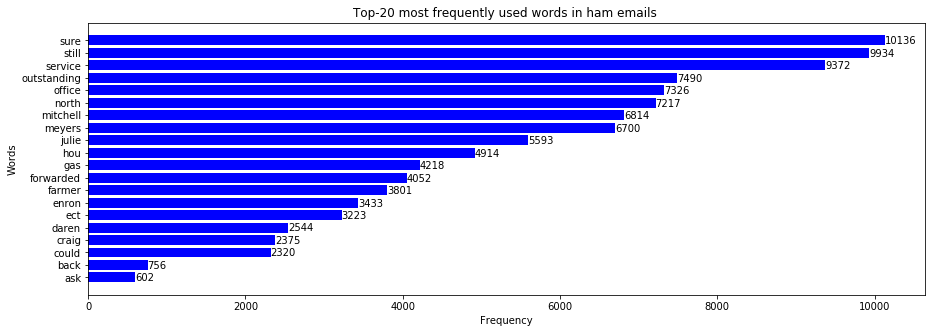

Above bar plot shows top-20 most frequently used words in non-spam i.e. ham emails and show their relative frequencies. “Sure” having the highest occurring frequency of 10136, “still” being the second highest with frequency 9934 and “ask” being the lowest from the top 20 having occurring frequency of 602.
The word Julie has occurred 15684 times and which is one of the top 20 most frequent word and it represent some person’s name.
Most of the words which are there in top 20 are words having relation to office, work, which pass useful information not like vague text used for promotion, marketing, etc.



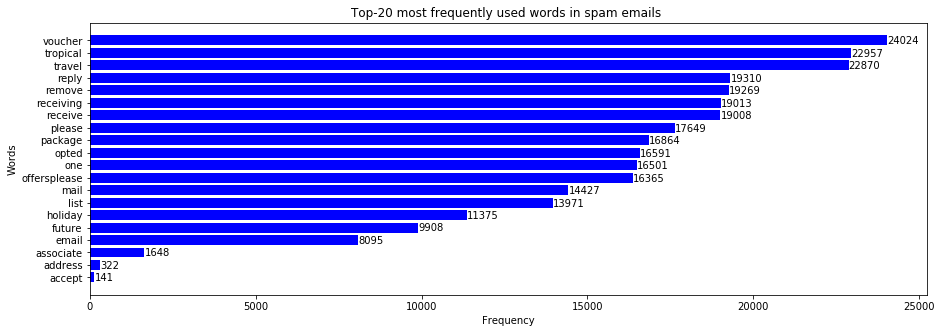

Above bar plot shows top-20 most frequently used words in spam emails and show their relative frequencies. “voucher” having the highest occurring frequency of 24024, “tropical” being the second highest with frequency 22957 and “accept” being the lowest from the top 20 having occurring frequency of 141.
Most of the words which are there in top 20 words are vague words mostly used for used for promotion, marketing, travel, etc. such as voucher, travel, reply, gift, package, opted, holiday, etc 



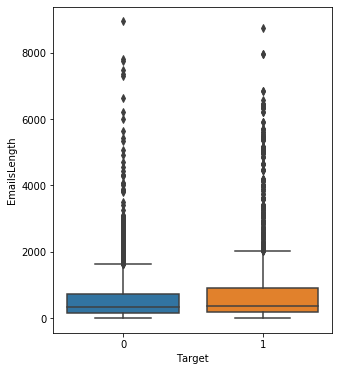

Above box plot shows distribution if email length for ham and spam. Median length for both the type of mails is approximately same and is around 300 to 400 words.
There are lot of outliers in both the cases, for ham number of mails count have greater than 3300 words start reducing and for spam its around 4200 words.



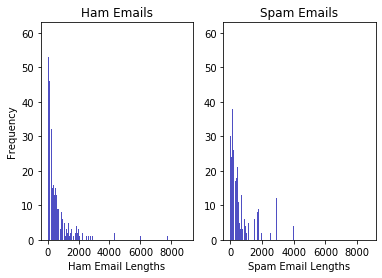

Above histogram shows distribution of ham and spam mails based on email lengths, there are more number of ham mails with less word count as compared to spam mails.
But, there is not significant difference between the two, so we cannot state a baseline for the same.


-------- Calculated metrics from crossvalidated MultinomialNB() model --------
Confusion matrix describe the performance of a classification model on set of unseen data
Different rates can be calculated with Confusion matrix
[[2173   64]
 [  29 2208]]
True Positive Rate(TPR) for Crossvalidation MultinomialNB() = 0.9870362092087618
False Positive Rate(FPR) for Crossvalidation MultinomialNB() = 0.028609745194456863
Accuracy for Crossvalidation MultinomialNB() model = 0.9792132320071525
Maximum residual error for Crossvalidation MultinomialNB() model = 1
Mean absolute error for Crossvalidation MultinomialNB() model = 0.020786767992847562
Root Mean squared/out of sample error error for Crossvalidation MultinomialNB() model = 0

C:\Users\35389.LAPTOP-3QHIVNN4\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\35389.LAPTOP-3QHIVNN4\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\35389.LAPTOP-3QHIVNN4\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\35389.LAPTOP-3QHIVNN4\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv w


-------- Model's accuracy before tuning parameter --------

Multinomial Naive Bayes = 0.9168529280286097
Support Vector Classifier/Machine = 0.49748743718592964
Decision Tree Classifier = 0.923905240488155
Random Forest Classifier = 0.9511844938980617

-------- Model's accuracy after tuning parameter --------

Multinomial Naive Bayes = 0.9784637473079684
Support Vector Classifier/Machine = 0.9813352476669059
Decision Tree Classifier = 0.9253409906676239
Random Forest Classifier = 0.9691313711414213


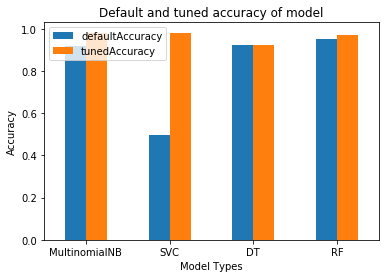


 Above bar plot shows accuracy of model before and after tuning for all the four models.
Accuracy of all the model is increased after tuning the parameter. Tuned SVC accuracy is highest amongst all 

-------- Best tuned model is SVC with below accuracy, best parameters and different metrics --------
Best tuned Parameters ={'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
Best tuned accuracy =0.9813352476669059
Accuracy for tuned SVC model = 0.49748743718592964
Maximum residual error for tuned SVC model = 1
Mean absolute error for tuned SVC model = 0.5025125628140703
Root Mean squared/out of sample error for tuned SVC model = 0.5025125628140703
Variance for tuned SVC model = -0.14449246914046276
Area Under the ROC Curve for tuned SVC model = 0.6292372881355932

Confusion matrix describe the performance of a classification model on set of unseen data
Confusion Matrix for tuned SVC model:
[[244 700]
 [  0 449]]
True Positive Rate(TPR) for tuned SVC model = 1.0
False Positive Rate(FPR) for tu

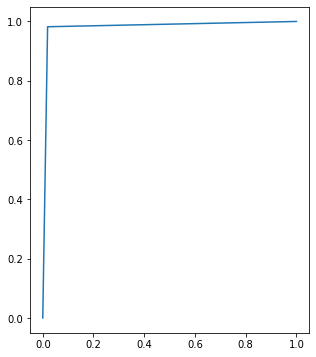

ROC curve is one of the most important evaluation metrics for checking any classification model’s performance and tells us how much the model is capable of distinguishing between classes

ROC graph is draws from the values which are calculated with the help of confusion matrix, area under the roc courve varies from 0 to 1 and states whether it's a good classifier or bad classifier

Summary:


Here we have to classifying a mail as ham or spam using some classifier. We have ham and spam mails in separate folders. These mails were read and store in form of dataframe where each row contains the mail text and a target variable storing whether its ham or spam mail, for ham target value is 0 and for spam it’s 1. Then these emails were pared through clean string, special character removal, stop word removal and lemmatisation functions to process the data. Then this process data was split in training and test in 70/30 ratio and separate ham and spam mail count was listed down and then for train

In [17]:
def main():
    """--------Reading files-------------"""
    dataHam = readDataFiles("C:/Users/35389.LAPTOP-3QHIVNN4/Documents/DS Workspace/Sem2/AML/Assignment1/enron1/ham/*.txt",0)
    dataSpam = readDataFiles("C:/Users/35389.LAPTOP-3QHIVNN4/Documents/DS Workspace/Sem2/AML/Assignment1/enron1/spam/*.txt",1)
    
    """--------Concatinating read data in a single dataframe-------------"""
    fullData = pd.concat([dataHam, dataSpam])
    
    """-------- cleaning dataframe --------"""
    fullData = cleanString(fullData)
    fullData = removeOneTwoCharWords(fullData)
    fullData = stopWordRemoval(fullData)
    fullData['Emails'] = fullData.Emails.apply(lemmatizeText)
    
    """-------- Splitting dataset in training and testing --------"""
    xData_Train,xData_Test,yData_Train,yData_Test = splitTestTrain(fullData)
    
    """-------- count ham and spam mails --------"""
    hamCountTest=yData_Test.value_counts()[0]
    spamCountTest=yData_Test.value_counts()[1]
    hamCountTrain=yData_Train.value_counts()[0]
    spamCountTrain=yData_Train.value_counts()[1]
    
    print("count ham and spam mails")
    print("\n--------------------------- Original Dataset ---------------------------")
    print("Total number of spam emails in training dataset = "+str(spamCountTrain))
    print("Total number of ham emails in training dataset = "+str(hamCountTrain))
    print("Total number of spam emails in test dataset = "+str(spamCountTest))
    print("Total number of ham emails in test dataset = "+str(hamCountTest))
    
    """-------- Concatinate train dataset to balance the dataset to remove bias--------"""
    concatinatedDataTrain = pd.concat([xData_Train, yData_Train], axis=1)
    
    print("\n--------------------------- Before balancing ---------------------------")
    print("Total number of spam emails in training dataset before balancing= "+str(concatinatedDataTrain.Target.value_counts()[1]))
    print("Total number of ham emails in training dataset before balancing= "+str(concatinatedDataTrain.Target.value_counts()[0]))
    
    hamData = concatinatedDataTrain[concatinatedDataTrain.Target==0]
    spamData = concatinatedDataTrain[concatinatedDataTrain.Target==1]
    upSampledData = upSampling(hamData,spamData)
    
    print("\n--------------------------- After balancing ---------------------------")
    print("Total number of spam emails in training dataset before balancing= "+str(upSampledData.Target.value_counts()[1]))
    print("Total number of ham emails in training dataset before balancing= "+str(upSampledData.Target.value_counts()[0]))
    
    """-------- splitting balanced dataset into predector and target variables --------"""
    yData_Train=upSampledData.Target
    xData_Train=upSampledData.drop("Target",axis=1)
     
    """-------- Feature extraction using TF-IDF --------"""
    vectorizerTf = TfidfVectorizer() # Initialisation or create the transform
    XData_Train_countsTf=vectorizerTf.fit_transform(xData_Train["Emails"]) # Tokenisation and building vocabulary
    XData_Test_tfidf = vectorizerTf.transform(xData_Test["Emails"]) # encode dataset
    
    """-------- Concatinationg Training dataset for EDA and Visualisation --------"""
    concatinatedData=pd.concat([xData_Train,yData_Train],axis=1)
    
    """-------- Finding top 20 features in spam and ham emails--------"""
    top20FrequentWords(concatinatedData,"ham",0)
    print("""Above bar plot shows top-20 most frequently used words in non-spam i.e. ham emails and show their relative frequencies. “Sure” having the highest occurring frequency of 10136, “still” being the second highest with frequency 9934 and “ask” being the lowest from the top 20 having occurring frequency of 602.
The word Julie has occurred 15684 times and which is one of the top 20 most frequent word and it represent some person’s name.
Most of the words which are there in top 20 are words having relation to office, work, which pass useful information not like vague text used for promotion, marketing, etc.
""")
    
    top20FrequentWords(concatinatedData,"spam",1)
    print("""Above bar plot shows top-20 most frequently used words in spam emails and show their relative frequencies. “voucher” having the highest occurring frequency of 24024, “tropical” being the second highest with frequency 22957 and “accept” being the lowest from the top 20 having occurring frequency of 141.
Most of the words which are there in top 20 words are vague words mostly used for used for promotion, marketing, travel, etc. such as voucher, travel, reply, gift, package, opted, holiday, etc 
""")
    
    """-------- Email Length Visualisation--------"""
    emailLength(concatinatedData)
    print("""Above box plot shows distribution if email length for ham and spam. Median length for both the type of mails is approximately same and is around 300 to 400 words.
There are lot of outliers in both the cases, for ham number of mails count have greater than 3300 words start reducing and for spam its around 4200 words.\n""")
    
    histEmailLength(concatinatedData)
    print("""Above histogram shows distribution of ham and spam mails based on email lengths, there are more number of ham mails with less word count as compared to spam mails.
But, there is not significant difference between the two, so we cannot state a baseline for the same.\n""")
  
    """-------- Training MultinomialNB() model and finding accuracy --------"""
    modelPickledMNB = trainModel(MultinomialNB(),XData_Train_countsTf, yData_Train)
    accuracyMNB,predectedMNB = calculateAccuracy(modelPickledMNB,XData_Test_tfidf,yData_Test)
    
    """-------- Crossvalidation on MultinomialNB() model and finding accuracy --------"""
    crossValidationScores,predictionsMNB,accuracyMNB = crossValidationMNB(modelPickledMNB,vectorizerTf,xData_Train,yData_Train,10)
    
    print("\n-------- Calculated metrics from crossvalidated MultinomialNB() model --------")
    print("""Confusion matrix describe the performance of a classification model on set of unseen data""")
    print("Different rates can be calculated with Confusion matrix")
    print(confusion_matrix(yData_Train, predictionsMNB))
    trueNegative, falsePositive, falseNegative, truePositive = confusion_matrix(yData_Train, predictionsMNB).ravel()
    print("True Positive Rate(TPR) for Crossvalidation MultinomialNB() = "+str(truePositive/(truePositive+falseNegative)))
    print("False Positive Rate(FPR) for Crossvalidation MultinomialNB() = "+str(falsePositive/(falsePositive+trueNegative)))
    print("Accuracy for Crossvalidation MultinomialNB() model = "+str(accuracy_score(yData_Train, predictionsMNB)))
    print("Maximum residual error for Crossvalidation MultinomialNB() model = "+str(max_error(yData_Train, predictionsMNB)))
    print("Mean absolute error for Crossvalidation MultinomialNB() model = "+str(mean_absolute_error(yData_Train, predictionsMNB)))
    print("Root Mean squared/out of sample error error for Crossvalidation MultinomialNB() model = "+str(mean_squared_error(yData_Train, predictionsMNB)))
    
    """-------- Tuning Multinomial Naive Bayes model--------"""
    tunedParameter={'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 'fit_prior':[True,False],'class_prior':[None]}
    bestParameterMNB,tunedAccuracyMNB,tunedPredectedMNB=tunedModel(MultinomialNB(),tunedParameter,XData_Train_countsTf,yData_Train,
                                                XData_Test_tfidf,yData_Test)
    
    """-------- Training Support Vector Machine/Classifier and finding accuracy --------"""
    modelPickledSVC = trainModel(svm.SVC(),XData_Train_countsTf, yData_Train)
    accuracySVC,predectedSVC = calculateAccuracy(modelPickledSVC,XData_Test_tfidf,yData_Test)
    
    """-------- Tuning Support Vector Machine/Classifier --------"""
    tunedParameter={'kernel':['linear','rbf'],'gamma':[1e-3,1e-4],'C':[1,10,100,1000]}
    bestParameterSVC,tunedAccuracySVC,tunedPredectedSVC=tunedModel(svm.SVC(),tunedParameter,XData_Train_countsTf,yData_Train,XData_Test_tfidf,yData_Test)
    
    """-------- Training Decision Tree Classifier and finding accuracy --------"""
    modelPickledDT = trainModel(DecisionTreeClassifier(),XData_Train_countsTf, yData_Train)
    accuracyDT,predectedDT = calculateAccuracy(modelPickledDT,XData_Test_tfidf,yData_Test)
    
    """-------- Tuning Decision Tree Classifier --------"""
    tunedParameter={'criterion':['gini','entropy'], 'splitter':['random','best'],'max_depth':[None,5],
                    'min_samples_split':[2,3,4,5],'min_samples_leaf':[1,2,3]}
    bestParameterDT,tunedAccuracyDT,tunedPredectedDT=tunedModel(DecisionTreeClassifier(),tunedParameter,XData_Train_countsTf,yData_Train,
                                        XData_Test_tfidf,yData_Test)
    
    """-------- Training Random Forest Classifier and finding accuracy --------"""
    modelPickledRF = trainModel(RandomForestClassifier(),XData_Train_countsTf, yData_Train)
    accuracyRF,predectedRF = calculateAccuracy(modelPickledRF,XData_Test_tfidf,yData_Test)
    
    """-------- Tuning Random Forest model  --------"""
    tunedParameter={'criterion':['gini','entropy'], 'n_estimators':[30,70,90],'max_depth':[None,5],
                    'min_samples_split':[2,3],'min_samples_leaf':[2,3]}
    bestParameterRF,tunedAccuracyRF,tunedPredectedRF=tunedModel(RandomForestClassifier(),tunedParameter,XData_Train_countsTf,yData_Train,
                                        XData_Test_tfidf,yData_Test)
    
    print("\n-------- Model's accuracy before tuning parameter --------\n")
    print("Multinomial Naive Bayes = "+str(accuracyMNB))
    print("Support Vector Classifier/Machine = "+str(accuracySVC))
    print("Decision Tree Classifier = "+str(accuracyDT))
    print("Random Forest Classifier = "+str(accuracyRF))
    
    print("\n-------- Model's accuracy after tuning parameter --------\n")
    print("Multinomial Naive Bayes = "+str(tunedAccuracyMNB))
    print("Support Vector Classifier/Machine = "+str(tunedAccuracySVC))
    print("Decision Tree Classifier = "+str(tunedAccuracyDT))
    print("Random Forest Classifier = "+str(tunedAccuracyRF))
    
    
    """-------- creating a list of accuracy of models before tuning --------"""
    defaultAccuracy=[accuracyMNB,accuracySVC,accuracyDT,accuracyRF]
    
    """-------- creating a list of accuracy of models after tuning --------"""
    tunedAccuracy=[tunedAccuracyMNB,tunedAccuracySVC,tunedAccuracyDT,tunedAccuracyRF]

    """-------- Ploting Accuracy of different models --------"""
    index = ['MultinomialNB', 'SVC', 'DT','RF']
    accuracyDF=pd.DataFrame({'defaultAccuracy': defaultAccuracy,'tunedAccuracy': tunedAccuracy}, index=index)
    accuracyDF.plot.bar(rot=0)
    plt.xlabel('Model Types')
    plt.ylabel('Accuracy')
    plt.title('Default and tuned accuracy of model')
    plt.show()
    
    print("""\n Above bar plot shows accuracy of model before and after tuning for all the four models.
Accuracy of all the model is increased after tuning the parameter. Tuned SVC accuracy is highest amongst all """)
    
    print("\n-------- Best tuned model is SVC with below accuracy, best parameters and different metrics --------")
    print("Best tuned Parameters ="+str(bestParameterSVC))
    print("Best tuned accuracy ="+str(tunedAccuracySVC))
    print("Accuracy for tuned SVC model = "+str(accuracy_score(yData_Test, predectedSVC)))
    print("Maximum residual error for tuned SVC model = "+str(max_error(yData_Test, predectedSVC)))
    print("Mean absolute error for tuned SVC model = "+str(mean_absolute_error(yData_Test, predectedSVC)))
    print("Root Mean squared/out of sample error for tuned SVC model = "+str(mean_squared_error(yData_Test, predectedSVC)))
    print("Variance for tuned SVC model = "+str(explained_variance_score(yData_Test, predectedSVC)))
    print("Area Under the ROC Curve for tuned SVC model = "+str(roc_auc_score(yData_Test, predectedSVC)))
    
    print("""\nConfusion matrix describe the performance of a classification model on set of unseen data""")
    print("Confusion Matrix for tuned SVC model:")
    print(confusion_matrix(yData_Test, predectedSVC))
    trueNegative, falsePositive, falseNegative, truePositive = confusion_matrix(yData_Test, predectedSVC).ravel()
    print("True Positive Rate(TPR) for tuned SVC model = "+str(truePositive/(truePositive+falseNegative)))
    print("False Positive Rate(FPR) for tuned SVC model = "+str(falsePositive/(falsePositive+trueNegative)))
    
    print("\n-------- ROC curve for tuned SVC model --------")
    
    fpr, tpr, thresholds = roc_curve(yData_Test, tunedPredectedSVC)
    plt.figure(figsize=(5,6))
    plt.plot(fpr, tpr)
    plt.show()
    print("ROC curve is one of the most important evaluation metrics for checking any classification model’s performance and tells us how much the model is capable of distinguishing between classes\n")
    print("ROC graph is draws from the values which are calculated with the help of confusion matrix, area under the roc courve varies from 0 to 1 and states whether it's a good classifier or bad classifier\n")
    
    print("Summary:\n")
    print("""\nHere we have to classifying a mail as ham or spam using some classifier. We have ham and spam mails in separate folders. These mails were read and store in form of dataframe where each row contains the mail text and a target variable storing whether its ham or spam mail, for ham target value is 0 and for spam it’s 1. Then these emails were pared through clean string, special character removal, stop word removal and lemmatisation functions to process the data. Then this process data was split in training and test in 70/30 ratio and separate ham and spam mail count was listed down and then for training set balancing of dataset was performed to remove any bias against a specific type of data.
Then feature extraction was performed with the help of TF-IDF and model training, prediction and tuning was performed on four different model i.e. Multinomial Naïve Bayes, Support Vector Machine, Decision tree and Random Forest. Out of all these four-best models after tuning the parameter was of SVC i.e. Support vector classifier.  
""")
main()